<a href="https://colab.research.google.com/github/astrodatos/proyecto_neuralclusters/blob/master/Neural_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se predecirá la temperatura efectiva de una estrella a través de sus magnitudes absolutas en cinco bandas fotométricas (problema de regresión). Se ha utilizado la base de datos del SDSS, consultando el mismo a través de astroquery.

In [0]:
!pip install --pre --quiet astroquery

In [76]:
from __future__ import absolute_import, division, print_function, unicode_literals

from time import time
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

1.14.0


## Datos del SDSS

Disponible en enlace



###Consulta con Astroquery###

In [0]:
t_ini = time()

data = SDSS.query_sql("""SELECT TOP 100000
                      p.fiberMag_u, p.fiberMag_g, p.fiberMag_r, p.fiberMag_i, 
                      p.fiberMag_z, s.elodieTEff
                   
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class = 'STAR'
                      
                      """)

In [196]:
datapd=data.to_pandas()
datapd = datapd[(datapd != -9999).dropna()]
datapd = datapd.dropna()
print(datapd)

       fiberMag_u  fiberMag_g  fiberMag_r  fiberMag_i  fiberMag_z  elodieTEff
0        21.83337    19.27120    17.89960    17.14513    16.73332        3980
1        23.37259    21.07802    19.91400    19.48223    19.26434        4382
2        23.94263    24.11839    22.72208    20.04225    18.71980        6361
3        22.84750    21.49752    20.73321    19.30991    18.36115        3717
4        18.93307    17.95865    17.64219    17.51762    17.51487        6000
5        20.80194    19.86347    19.59687    19.50837    19.61006        6500
6        18.29236    17.25009    17.02323    16.96966    16.98678        6767
7        19.74772    18.87180    18.58598    18.47800    18.41686        6500
8        19.49793    18.24680    17.67236    17.45136    17.29030        5324
9        22.66463    21.38908    20.58021    20.34503    20.06815        5164
10       20.80861    19.15268    18.41664    18.10976    17.99520        4752
11       22.98514    20.16630    18.74796    18.25244    17.9125

### Separación entre datos de entrenamiento y datos de prueba 

In [0]:
train_datapd = datapd.sample(frac=0.8,random_state=0)
test_datapd = datapd.drop(train_datapd.index)

### Chequeo a los datos

Estadísticas:

In [198]:
train_stats = train_datapd.describe()
train_stats.pop("elodieTEff")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
fiberMag_u,79991.0,20.969660,2.135396,14.01740,19.377115,20.78086,22.629585,27.39022
fiberMag_g,79991.0,19.574465,2.006445,13.51540,18.083710,19.41794,21.282200,28.41938
fiberMag_r,79991.0,18.971894,1.895552,12.84478,17.509110,18.92027,20.623205,24.66934
fiberMag_i,79991.0,18.648802,1.824266,12.73436,17.241720,18.64167,20.135515,25.33082
fiberMag_z,79991.0,18.460820,1.806380,12.13546,17.081655,18.40500,19.878905,25.42421


### Separacaión entre atributos y etiquetas

En este caso, la temperatura es la etiqueta, mientras que los atributos son las magnitudes absolutas en cinco bandas fotométricas.

In [0]:
train_labels = train_datapd.pop('elodieTEff')
test_labels = test_datapd.pop('elodieTEff')

train_feat = train_datapd
test_feat = test_datapd


### Normalización de los datos


In [0]:
def norm(x):
  r=(x-x.mean())/x.std()
  return r

In [0]:
norm_train_labels = norm(train_labels)
norm_train_feat = norm(train_feat)

norm_test_feat = norm(test_feat)

Se utilizarán los datos normalizados para entrenar el modelo.


## El modelo

###Estructura de la red neuronal

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.tanh, input_shape=[len(train_datapd.keys())]),
    layers.Dense(1, activation=tf.nn.tanh),
    #layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

###Desnormalización

In [0]:
def desnorm(dato, media, std):
  datonuevo = dato*std + media
  return datonuevo

### Inspección del modelo

In [204]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 6         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 2         
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

In [205]:
# Imprime un punto por cada epoch completado
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  norm_train_feat, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

El progreso de entrenamiento del sistema está en el objeto `history`.

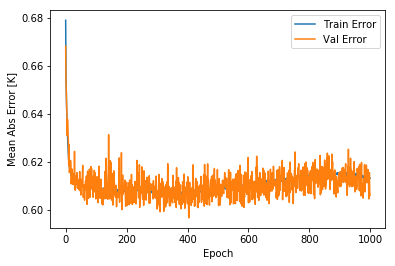

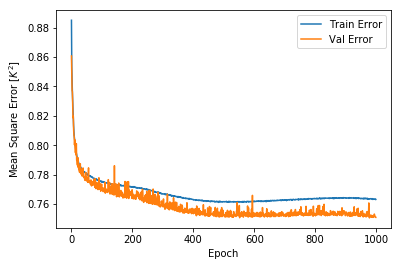

In [206]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

print(history)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [K]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$K^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

###Tiempo de Ejecución

In [0]:
t_fin = time()
t_ejecucion = t_fin - t_ini

### Predicción con los datos de prueba

(2986.9207189635135,
 14086.542292048332,
 2986.9066802372204,
 14086.528253322038)

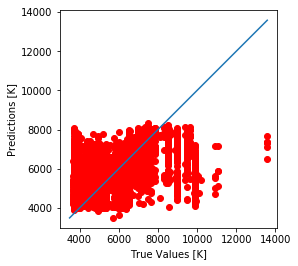

In [208]:
test_predictions = model.predict(norm_test_feat).flatten()

test_predictions = desnorm(test_predictions, train_labels.mean(), train_labels.std())
m1 = min(test_labels)
M1 = max(test_labels)

m2 = min(test_predictions)
M2 = max(test_predictions)

m = min([m1, m2])
M = max([M1, M2])

plt.scatter(test_labels, test_predictions, color='red')
plt.plot([m , M], [m, M])
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,100])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

Notemos que nuestro modelo se debe acercar a la función de  identidad. Ahora veamos la distribución del error absoluto:



### Errores

Tiempo de Ejecución: 2731.450212240219
Error Absoluto Medio: 936.4125366210938
Error Cuadrático Medio: 1808218.5


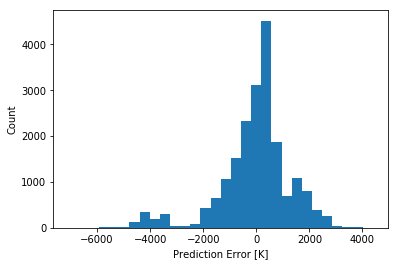

In [209]:
import numpy as np
error = test_predictions - test_labels
error2 = error**2

plt.hist(error, bins = 30)
plt.xlabel("Prediction Error [K]")
_ = plt.ylabel("Count")

MeanAbsError = np.abs(error).mean()
MeanSQError = error2.mean()

print('Tiempo de Ejecución:', t_ejecucion)
print('Error Absoluto Medio:', MeanAbsError)
print('Error Cuadrático Medio:', MeanSQError)